<h1 align='center'>Домашнее задание 3</h1>
<h3 align='center'> Rossmann Store Sales: 

Forecast sales using store, promotion, and competitor data </h3>

Введение в анализ данных (первый семестр)
Добрый день, коллеги!

Дедлайн сдачи домашнего задания: 27 апреля, 22:00. После дедлайна решения не принимаются.

В данном домашнем задании вам придется учавствовать в конкурсе [Rossman Store Sales](https://www.kaggle.com/c/rossmann-store-sales). Ваша задача получить наиболее высокий результат на Private Leaderboard, используя только те методы, которые вы узнали до сегодняшнего дня на курсах Техносферы. Оценка домашнего задания будет производиться через kaggle kernels. До дедлайна вам необходимо прислать на почту письмо с ссылкой на ваш kernel. Не забудьте указать правильно тему:)

Удачи!

# Files

- train.csv - historical data including Sales

- test.csv - historical data excluding Sales

- sample_submission.csv - a sample submission file in the correct format

- store.csv - supplemental information about the stores

# Data fields

Most of the fields are self-explanatory. The following are descriptions for those that aren't

- Id - an Id that represents a (Store, Date) duple within the test set

- Store - a unique Id for each store

- Sales - the turnover for any given day (this is what you are predicting)

- Customers - the number of customers on a given day

- Open - an indicator for whether the store was open: 0 = closed, 1 = open

- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None

- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools

- StoreType - differentiates between 4 different store models: a, b, c, d

- Assortment - describes an assortment level: a = basic, b = extra, c = extended

- CompetitionDistance - distance in meters to the nearest competitor store

- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened

- Promo - indicates whether a store is running a promo on that day

- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2

- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [34]:
%matplotlib inline

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

In [2]:
#Create random seed
RND_SEED=1

In [4]:
samp = pd.read_csv('data/sample_submission.csv')
store =  pd.read_csv('data/store.csv')
test = pd.read_csv('data/test.csv')
train =  pd.read_csv('data/train.csv')

In [5]:
#Для того, чтобы одновременно менять фичи у test и train объединим датасеты
train['Set'] = 1
test['Set'] = 0
df = pd.concat([train,test])

In [36]:
#Преобразуем поле c Date, чтобы посмотреть на продажи по месяцам
train['Date'] = train['Date'].apply(lambda x: (str(x)[:7]))

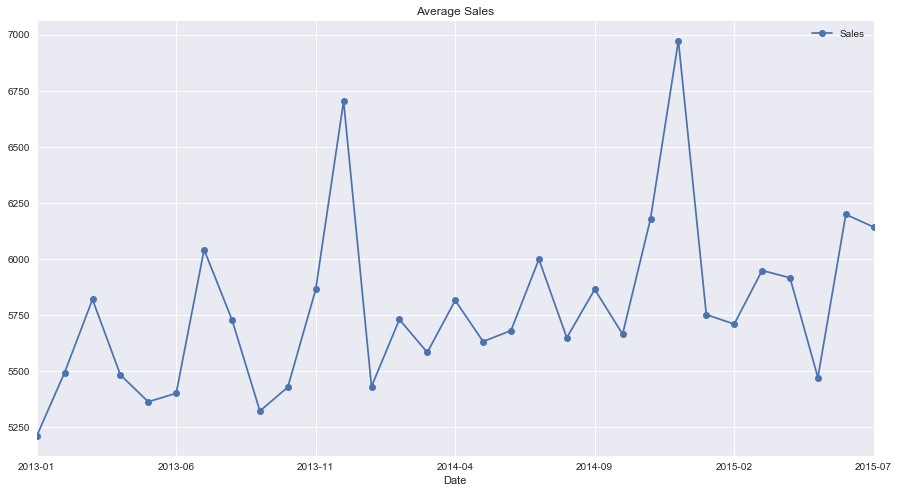

In [37]:
#Посмотрим на средние продажи по месяцам
average_sales    = train.groupby('Date')["Sales"].mean()
fig, axis1 = plt.subplots(1,1,sharex=True,figsize=(15,8))
ax1 = average_sales.plot(legend=True,ax=axis1,marker='o',title="Average Sales")

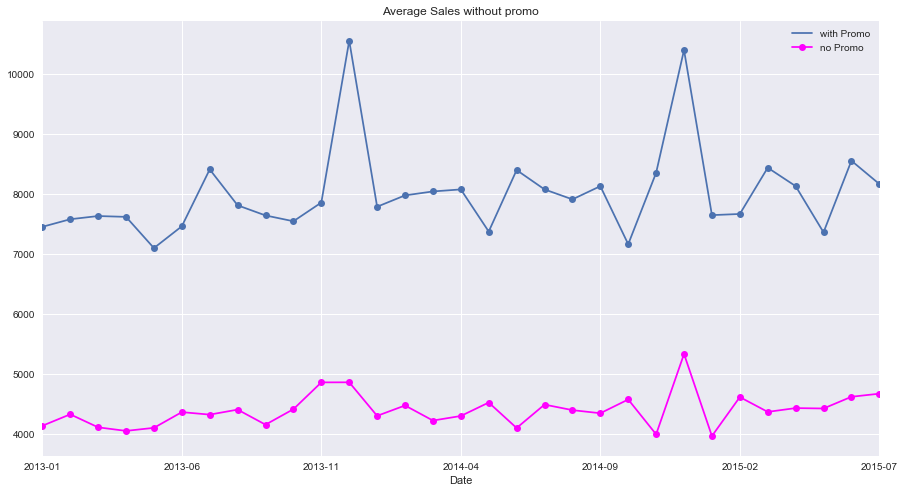

In [38]:
#Посмотрим как отличаются продажи в те месяца, когда была реклама, и когда ее не было
train_promo = train[train['Promo']==1]
train_no = train[train['Promo']==0]
avp = train_promo.groupby('Date')["Sales"].mean()
avn = train_no.groupby('Date')["Sales"].mean()
fig, (axis1) = plt.subplots(1,1,sharex=True,figsize=(15,8))
avp.plot(legend=True,ax=axis1,marker='o',title="Average Sales with promo", label='with Promo')
avn.plot(legend=True,ax=axis1,marker='o',title="Average Sales without promo",colormap="spring", label='no Promo')

In [6]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [7]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [8]:
df.head()

,Customers,Date,DayOfWeek,Id,Open,Promo,Sales,SchoolHoliday,Set,StateHoliday,Store
0,555.0,2015-07-31,5,NaN,1.0,1,5263.0,1,1,0,1
1,625.0,2015-07-31,5,NaN,1.0,1,6064.0,1,1,0,2
2,821.0,2015-07-31,5,NaN,1.0,1,8314.0,1,1,0,3
3,1498.0,2015-07-31,5,NaN,1.0,1,13995.0,1,1,0,4
4,559.0,2015-07-31,5,NaN,1.0,1,4822.0,1,1,0,5


In [10]:
#Поля имеют два значения как "0" так и 0
df["StateHoliday"].loc[df["StateHoliday"] == "0"] = 0

In [11]:
#Преобразуем категориальные признаки StoreType, Assortment, StateHoliday
store['StoreType'] = store['StoreType'].astype('category').cat.codes
store['Assortment'] = store['Assortment'].astype('category').cat.codes
df["StateHoliday"] = df["StateHoliday"].astype('category').cat.codes

In [12]:
df['StateHoliday'].value_counts()

0    1027067
1      20440
2       6690
3       4100
Name: StateHoliday, dtype: int64

In [13]:
#Найдем среднее число продавцов и покупок по магазинам и объединим с таблицей store
average_sales_customers = train.groupby('Store')[["Sales", "Customers"]].mean()
sales_customers_df = pd.DataFrame({'Store':average_sales_customers.index,
                      'Sales':average_sales_customers["Sales"], 'Customers': average_sales_customers["Customers"]}, 
                      columns=['Store', 'Sales', 'Customers'])
store = pd.merge(sales_customers_df, store, on='Store')

store.head()

,Store,Sales,Customers,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,3945.704883,467.646497,2,0,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,4122.991507,486.045648,0,0,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5741.253715,620.286624,0,0,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,8021.769639,1100.057325,2,2,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,3867.110403,444.360934,0,0,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [14]:
#Видно, что в таблице присутствуют нулевые признаки
store.isnull().sum()

Store                          0
Sales                          0
Customers                      0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [15]:
#Удалим те магазины, который были открыты, но не торговали
df = df.loc[~((df['Open'] == 1) & (df['Sales'] == 0))]

In [16]:
#Сохраним айдишники закрытых магазинов, в качестве ответа им потом будут присвоены нули.
closed_ids = df["Id"][df["Open"] == 0].values

In [17]:
#Так как в нашей таблице иногда встречались нули, удалим их из closed_ids
closed_ids = closed_ids[~np.isnan(closed_ids)]

In [18]:
#Удалим закратые магазины из таблицы, они ни на что не влияют
df = df[df["Open"] != 0]

In [20]:
#Прежде чем объединять таблицу store и train преобразуем поле CompetitionOpenSinceYear
def convertCompetitionOpen(df):
    try:
        date = '{}-{}'.format(int(df['CompetitionOpenSinceYear']), int(df['CompetitionOpenSinceMonth']))
        return pd.to_datetime(date)
    except:
        return np.nan

store['CompetitionOpenInt'] = store.apply(lambda df: convertCompetitionOpen(df), axis=1).astype(np.int64)

In [21]:
#У таблицы store выделим основные фичи
features_store = ['Store', 'StoreType', 'Assortment', 
                  'CompetitionDistance', 'CompetitionOpenInt']
features_y = ['Sales']

In [22]:
df.head()

,Customers,Date,DayOfWeek,Id,Open,Promo,Sales,SchoolHoliday,Set,StateHoliday,Store
0,555.0,2015-07-31,5,NaN,1.0,1,5263.0,1,1,0,1
1,625.0,2015-07-31,5,NaN,1.0,1,6064.0,1,1,0,2
2,821.0,2015-07-31,5,NaN,1.0,1,8314.0,1,1,0,3
3,1498.0,2015-07-31,5,NaN,1.0,1,13995.0,1,1,0,4
4,559.0,2015-07-31,5,NaN,1.0,1,4822.0,1,1,0,5


In [23]:
df = pd.merge(df, store[features_store], how='left', on=['Store'])

In [24]:
#Выделим основные фичи на основе которых будем предсказывать ответ
features_x = ['DayOfWeek','Promo', 'SchoolHoliday', 'StateHoliday', 'StoreType', 'Assortment', 
                  'CompetitionDistance', 'CompetitionOpenInt']

In [25]:
df[features_x].head()

,DayOfWeek,Promo,SchoolHoliday,StateHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenInt
0,5,1,1,0,2,0,1270.0,1220227200000000000
1,5,1,1,0,0,0,570.0,1193875200000000000
2,5,1,1,0,0,0,14130.0,1164931200000000000
3,5,1,1,0,2,2,620.0,1251763200000000000
4,5,1,1,0,0,0,29910.0,1427846400000000000


In [26]:
df[features_x].isnull().sum()

DayOfWeek                 0
Promo                     0
SchoolHoliday             0
StateHoliday              0
StoreType                 0
Assortment                0
CompetitionDistance    2262
CompetitionOpenInt        0
dtype: int64

In [27]:
#Всем Nan в CompetitionDistance присвоим -1
df['CompetitionDistance'] = df['CompetitionDistance'].fillna(-1)

In [28]:
#Проверим снова
df[features_x].isnull().sum()

DayOfWeek              0
Promo                  0
SchoolHoliday          0
StateHoliday           0
StoreType              0
Assortment             0
CompetitionDistance    0
CompetitionOpenInt     0
dtype: int64

In [29]:
df[features_x].head()

,DayOfWeek,Promo,SchoolHoliday,StateHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenInt
0,5,1,1,0,2,0,1270.0,1220227200000000000
1,5,1,1,0,0,0,570.0,1193875200000000000
2,5,1,1,0,0,0,14130.0,1164931200000000000
3,5,1,1,0,2,2,620.0,1251763200000000000
4,5,1,1,0,0,0,29910.0,1427846400000000000


In [30]:
#Выделим обучающую выборку
X_train, y_train = np.array(df.loc[(df['Set'] == 1)][features_x]),np.array(df.loc[(df['Set'] == 1)][features_y])

In [31]:
#Преобразования для для пременения модели, понадобиться в дальнейшем.
y_train=np.ravel(y_train)

In [32]:
#Так как признаки до сих пор отшкалированы по-разному, то посмотрим как 
#поведет себя случайный лес, который требует минимальной предобработки данных.
#Попробуем подобрать наилучшую глубину дерева.
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

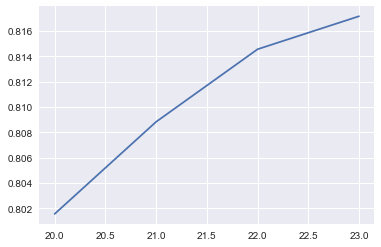

In [35]:
scores = []
for d in tqdm_notebook(range(20,24)):
   model =  RandomForestRegressor(max_depth=d)
   scores.append(cross_val_score(model, X_train, y_train, cv=5, scoring='r2').mean())
plt.plot(range(20,24), scores)

In [ ]:
#Отсюда можно заключить, что 24 является наилучшей глубиной дерева, 
#можно кончено задать значение больше, но есть вероятность переобучиться на трейновых данных.

In [40]:
#Обучим нашу модель
randomForest = RandomForestRegressor(max_depth=24)
randomForest.verbose = True
randomForest.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   23.2s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=24,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=True, warm_start=False)

In [41]:
#Выделим тестовую дату
X_test=np.array(df.loc[(df['Set'] == 0)][features_x])
X_test.shape

(35104, 8)

In [42]:
#Предскажем результат
result = randomForest.predict(X_test)

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


In [43]:
#Первый дата фрейм - это открытые магазины
open_ids = df[df['Id'].isnull() == False & (df['Set'] == 0)]['Id']
a = pd.DataFrame({ "Id": open_ids, "Sales": result})

In [44]:
#Второй - закрытые, их заполним нулями
zeroes = np.zeros(closed_ids.shape)
b = pd.DataFrame({ "Id": closed_ids, "Sales": zeroes})

In [45]:
#Объединим, отсортируем по Id и преобразуем поле Id в int. Получим submission.csv
submission =  pd.concat([a,b], ignore_index=True)
submission.sort_values('Id', inplace=True)
submission['Id']=submission['Id'].astype(int)
submission.to_csv('data/submission.csv', index=False)

In [47]:
pd.read_csv('data/submission.csv').head()

,Id,Sales
0,1,4970.429539
1,2,8004.060251
2,3,9089.962050
3,4,7102.431215
4,5,6619.392155


In [ ]:
#Score получился 0.16549